In [17]:
import numpy as np
import torch
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def dxdt(x,t):
    dxdt = 0.5/(x + 2)
    return dxdt

# Length of time to solve for (time points = tf + 1, each pt = 1 min)
tf = 100 # min
timepts = tf + 1
tvect = np.linspace(0, tf, timepts)

x_list = np.linspace(0, 10, 100000)

x_inputs = np.zeros(len(x_list))
x_outputs = np.zeros(len(x_list))
row = 0

for x_ind, x in enumerate(x_list):

    x_inputs[x_ind] = x
    x_outputs[x_ind] = odeint(dxdt, x, t=[0,1])[1][0]

    row += 1

print(row)

100000


In [18]:
print(x_inputs)


[0.00000e+00 1.00001e-04 2.00002e-04 ... 9.99980e+00 9.99990e+00
 1.00000e+01]


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import copy

x_inputs = np.vstack((x_inputs))
print(np.shape(x_inputs))
x_outputs = np.vstack((x_outputs))
print(np.shape(x_outputs))
x_inputs_tens = torch.tensor(x_inputs, dtype=torch.float32)

x_outputs_tens = torch.tensor(x_outputs, dtype=torch.float32)

# Define neural network
class x_next(nn.Module):
    def __init__(self):
        super(x_next, self).__init__()
        self.layer1 = nn.Linear(1, 80)  # Input layer to hidden layer
        self.layer2 = nn.Linear(80, 1) # Hidden layer to output layer

    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        x = (self.layer2(x))
        return x
    
# Initialize the model
x_next_model = x_next()

# Create data set and data loader to use batches
dataset = TensorDataset(x_inputs_tens, x_outputs_tens)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

# Define loss function and optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(x_next_model.parameters(), lr=0.01)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

best_loss = float('inf')
patience = 50
patience_left = patience

# Train model
num_epochs = 500
for epoch in range(num_epochs):
    for x_batch, y_batch in dataloader:
        # Evaluate model
        outputs = x_next_model(x_batch)
        # Calculate loss
        loss = loss_func(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Step the scheduler and print the learning rate if it changes
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != current_lr:
        print(f'Epoch {epoch+1}: reducing learning rate from {current_lr:.5f} to {new_lr:.5f}')

    # Early stopping criteria
    if loss <= best_loss:
        best_loss = loss
        patience_left = patience
        best_model_weights = copy.deepcopy(x_next_model.state_dict())
        best_epoch = epoch
    else:
        patience_left -= 1
        if patience_left == 0:
            break

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.10f}')

# Use the best weights in the model
x_next_model.load_state_dict(best_model_weights)

# Determine the best epoch and lost value when complete
print(f"Best epoch: {best_epoch}")
print(f"Smallest loss value: {best_loss:.8f}")

(100000, 1)
(100000, 1)
Epoch [10/500], Loss: 0.0020777311
Epoch [20/500], Loss: 0.0008661891
Epoch [30/500], Loss: 0.0001769113
Epoch [40/500], Loss: 0.0009456326
Epoch [50/500], Loss: 0.0011207652
Epoch [60/500], Loss: 0.0000804365
Epoch [70/500], Loss: 0.0000744332
Epoch [80/500], Loss: 0.0001209800
Epoch [90/500], Loss: 0.0010631740
Epoch [100/500], Loss: 0.0000548104
Epoch [110/500], Loss: 0.0002826799
Epoch 118: reducing learning rate from 0.01000 to 0.00100
Epoch [120/500], Loss: 0.0000143599
Epoch [130/500], Loss: 0.0000126971
Epoch [140/500], Loss: 0.0000131419
Epoch [150/500], Loss: 0.0000105687
Epoch [160/500], Loss: 0.0000093416
Epoch [170/500], Loss: 0.0000108609
Epoch [180/500], Loss: 0.0000075992
Epoch [190/500], Loss: 0.0000065958
Epoch [200/500], Loss: 0.0000064598
Epoch [210/500], Loss: 0.0000044383
Epoch [220/500], Loss: 0.0000084322
Epoch [230/500], Loss: 0.0000217042
Epoch [240/500], Loss: 0.0000173497
Epoch 243: reducing learning rate from 0.00100 to 0.00010
Epoch

In [20]:
import tempfile
import torch.onnx
from omlt.io.onnx import write_onnx_model_with_bounds, load_onnx_neural_network_with_bounds

x_input_bounds = [(0,10)]

# Make random data for batch size, input size (dummy input to trace the model)
x_trace = torch.randn(1000, 1, requires_grad=True)

with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    torch.onnx.export(
        x_next_model,
        x_trace,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    write_onnx_model_with_bounds(f.name, None, x_input_bounds)
    print(f"Wrote PyTorch model to {f.name}")
    x_pytorch_model = f.name

Wrote PyTorch model to C:\Users\Jake\AppData\Local\Temp\tmpdtxf3jy4.onnx


In [21]:
import os
from omlt.neuralnet import FullSpaceNNFormulation
import pyomo.environ as pyo
from omlt.neuralnet.activations import ComplementarityReLUActivation
from omlt import OmltBlock

# Import necessary libraries
from pyomo.environ import *  # Pyomo for optimization modeling
from pyomo.dae import *  # Differential algebraic equations module in Pyomo
from pyomo.gdp import Disjunct, Disjunction
import numpy as np  # Numpy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for plotting results
import math
from scipy.integrate import trapz
import time

# Import NN from ONNX with specified bounds
x_model_pyo = load_onnx_neural_network_with_bounds(x_pytorch_model)
# Remove the temporary file created
os.remove(x_pytorch_model)

# Confirm layers and bounds
print(x_model_pyo.scaled_input_bounds)
for layer_id, layer in enumerate(x_model_pyo.layers):
    print(f"{layer_id}\t{layer}\t{layer.activation}")

{0: (0, 10)}
0	InputLayer(input_size=[1], output_size=[1])	linear
1	DenseLayer(input_size=[1], output_size=[80])	sigmoid
2	DenseLayer(input_size=[80], output_size=[1])	linear


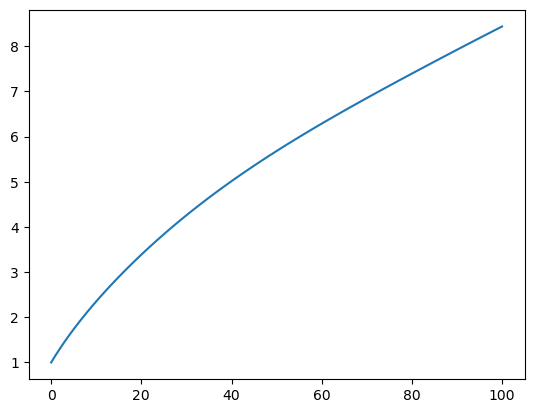

In [22]:
# Evaluate NN
def x_next_eval(x1):

    NN_input = np.vstack((x1))
    NN_input = torch.tensor(NN_input, dtype=torch.float32)

    x_next_model.eval()
    with torch.no_grad():
        x_test = x_next_model(NN_input).item()

    return x_test


x_init = 1
x_t = np.zeros(timepts)
x_t[0] = x_init

for t_ind in range(tf):
    x_val = np.array([x_t[t_ind]])
    x_t[t_ind+1] = x_next_eval(x_val)

plt.figure()
plt.plot(tvect, x_t)


Constraint skipped, t=start
Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower

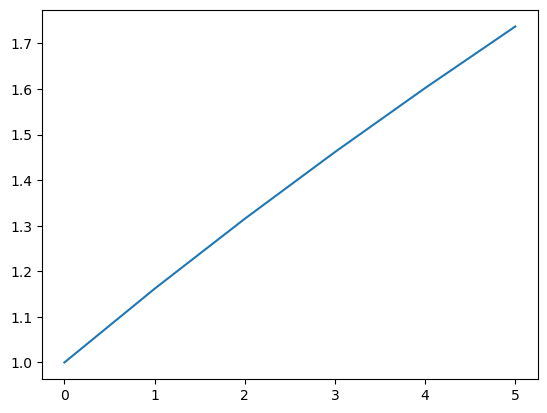

In [23]:
# Import necessary libraries
from pyomo.environ import *  # Pyomo for optimization modeling
from pyomo.dae import *  # Differential algebraic equations module in Pyomo
import numpy as np  # Numpy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for plotting results
from omlt.neuralnet import NetworkDefinition, FullSpaceNNFormulation, \
FullSpaceSmoothNNFormulation, ReducedSpaceSmoothNNFormulation, ReluBigMFormulation,\
ReluComplementarityFormulation, ReluPartitionFormulation

# Time horizon for the simulation
start_time = 0.0
end_time = 5.0

# Initialize the Concrete Model
model = ConcreteModel()

# Make discrete time points within specified bounds
time_points = list(range(int(start_time), int(end_time) + 1)) 

model.t = Set(initialize=time_points)
model.x = Var(model.t)

x_init = 1
model.x[start_time].fix(x_init)

model.nn_x = OmltBlock()
x_formulation = ReducedSpaceSmoothNNFormulation(x_model_pyo)
model.nn_x.build_formulation(x_formulation)

def state_update_rule(m,t):

    if t == start_time:
        print('Constraint skipped, t=start')
        return Constraint.Skip
    prev_t = t-1

    x_val = np.array([m.x[prev_t].value])
    m.x[t] = x_next_eval(x_val)

    # m.nn_x.inputs[0] = m.x[prev_t].value
    # m.x[t] = m.nn_x.outputs[0]
    
    return Constraint.Skip

model.state_update_constraint = Constraint(model.t, rule=state_update_rule)

def obj_fxn(m):
    return 1.0

model.obj = Objective(rule=obj_fxn)

# Solver setup and solution
solver = SolverFactory('ipopt')  # Using IPOPT solver
results = solver.solve(model, tee=True)  # Solve the model, tee=True for verbose output
print(results)  # Print solver results


times = np.array([t for t in model.t])  # Extract time points
x_pts = np.array([model.x[t].value for t in times])

print(times)
print(x_pts)

plt.figure()
plt.plot(times, x_pts)

# List appending OmltBlock()

In [24]:
# Import necessary libraries
from pyomo.environ import *
# from pyomo.environ import IndexedBlock
# from pyomo.dae import *
import numpy as np
import matplotlib.pyplot as plt
from omlt.neuralnet import ReducedSpaceSmoothNNFormulation
import pyomo.kernel

# Time horizon for the simulation
start_time = 0.0
end_time = 5.0

# Initialize the Concrete Model
model = ConcreteModel()

# Make discrete time points within specified bounds
time_points = list(range(int(start_time), int(end_time) + 1)) 
model.t = Set(initialize=time_points)
# model.x_prev = Var(model.t)
model.x = Var(model.t, domain=Reals)

# Initial value for x
x_init = 1
model.x[int(start_time)].fix(x_init)




# model.nn_x = OmltBlock()
x_input_bounds = [(0,10)]

# Make random data for batch size, input size (dummy input to trace the model)
x_trace = torch.randn(1000, 1, requires_grad=True)

with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    torch.onnx.export(
        x_next_model,
        x_trace,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    write_onnx_model_with_bounds(f.name, None, x_input_bounds)
    print(f"Wrote PyTorch model to {f.name}")
    x_pytorch_model = f.name
# Neural network formulation
# Import NN from ONNX with specified bounds
x_model_pyo = load_onnx_neural_network_with_bounds(x_pytorch_model)
# Remove the temporary file created
os.remove(x_pytorch_model)


# Confirm layers and bounds
print(x_model_pyo.scaled_input_bounds)
for layer_id, layer in enumerate(x_model_pyo.layers):
    print(f"{layer_id}\t{layer}\t{layer.activation}")

x_formulation = ReducedSpaceSmoothNNFormulation(x_model_pyo)




# Define a set of indices
model.ind = Set(initialize=[1, 2, 3, 4, 5])

# Create a Block and index it using the defined set
model.omlt_blocks = Block(model.ind)

# Initialize each block with an OmltBlock
for i in model.ind:
    model.omlt_blocks[i].omlt_block = OmltBlock()



# OMLT block for neural network
model.nn_x = pyomo.core.kernel.block.block_list()
bob = OmltBlock()
print(isinstance(bob, pyomo.core.kernel.block.block))

for k in range(5):
    model.nn_x.add(OmltBlock())


print(model.nn_x)
for k in range(5):
    print(k)
    model.nn_x[k].build_formulation(x_formulation)




def input_connect(m,t):
    if t == model.t.last():
        print('Skipped input contraint for last time... last state is not fed to NN')
        return Constraint.Skip
    
    return m.nn_x[t].inputs[0] == m.x[t]
model.input_constraint = Constraint(model.t, rule=input_connect)


def output_connect(m,t):
    if t == model.t.first():
        print('Skipped first output contraint... state constraint is initial condition')
        return Constraint.Skip
    
    t_prev = m.t.prev(t)
    return m.x[t] == m.nn_x[t_prev].outputs[0]
model.output_constraint = Constraint(model.t, rule=output_connect)


    

# Objective function (trivial)
def obj_fxn(m):
    return 1.0

model.obj = Objective(rule=obj_fxn)

# Solver setup and solution
solver = SolverFactory('ipopt')
results = solver.solve(model, tee=True)
print(results)

# Extract and plot results
times = np.array([t for t in model.t])
x_pts = np.array([model.x[t].value for t in times])

plt.figure()
plt.plot(times, x_pts)
plt.xlabel('Time')
plt.ylabel('x')
plt.show()


Wrote PyTorch model to C:\Users\Jake\AppData\Local\Temp\tmpsgfzj3gm.onnx
{0: (0, 10)}
0	InputLayer(input_size=[1], output_size=[1])	linear
1	DenseLayer(input_size=[1], output_size=[80])	sigmoid
2	DenseLayer(input_size=[80], output_size=[1])	linear
False


AttributeError: 'block_list' object has no attribute 'add'

# Manual - separate variables per time point

Wrote PyTorch model to C:\Users\Jake\AppData\Local\Temp\tmpzv6l8lc0.onnx
Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:       55
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:       29
                     variables with only lower bounds: 

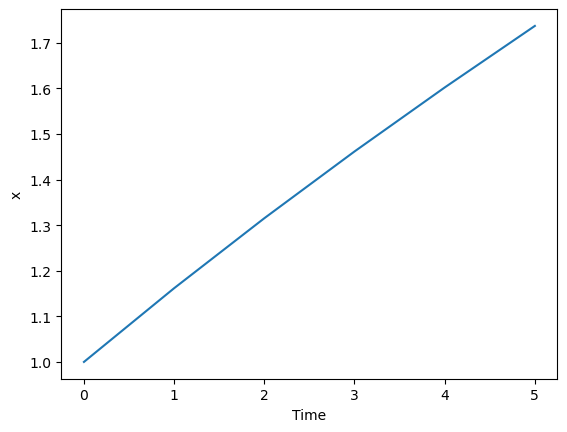

In [25]:
# Import necessary libraries
from pyomo.environ import *
# from pyomo.dae import *
import numpy as np
import matplotlib.pyplot as plt
from omlt.neuralnet import ReducedSpaceSmoothNNFormulation
import pyomo.kernel

# --------------------------- Save PyTorch NN and create NN formulation ---------------------- #

# model.nn_x = OmltBlock()
x_input_bounds = [(0,10)]

# Make random data for batch size, input size (dummy input to trace the model)
x_trace = torch.randn(1000, 1, requires_grad=True)

with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    torch.onnx.export(
        x_next_model,
        x_trace,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    write_onnx_model_with_bounds(f.name, None, x_input_bounds)
    print(f"Wrote PyTorch model to {f.name}")
    x_pytorch_model = f.name

# Import NN from ONNX with specified bounds
x_model_pyo = load_onnx_neural_network_with_bounds(x_pytorch_model)
# Remove the temporary file created
os.remove(x_pytorch_model)

# Neural network formulation - used loaded ONNX file
x_formulation = ReducedSpaceSmoothNNFormulation(x_model_pyo)


# -------------------------------- Set up Pyomo model ----------------------------- #


# Time horizon for the simulation
start_time = 0.0
end_time = 5.0

# Initialize the Concrete Model
model = ConcreteModel()

# Make discrete time points within specified bounds
time_points = list(range(int(start_time), int(end_time) + 1)) 
model.t = Set(initialize=time_points)
model.x = Var(model.t, domain=Reals)

# Initial value for x
x_init = 1
model.x[int(start_time)].fix(x_init)

# Create OmltBlock() for each time point
model.nn_x0 = OmltBlock()
model.nn_x1 = OmltBlock()
model.nn_x2 = OmltBlock()
model.nn_x3 = OmltBlock()
model.nn_x4 = OmltBlock()
model.nn_x5 = OmltBlock()

# Add formulation to each block
model.nn_x0.build_formulation(x_formulation)
model.nn_x1.build_formulation(x_formulation)
model.nn_x2.build_formulation(x_formulation)
model.nn_x3.build_formulation(x_formulation)
model.nn_x4.build_formulation(x_formulation)
model.nn_x5.build_formulation(x_formulation)

# Create constraint for each time point
def x0_input(m):
    return m.nn_x0.inputs[0] == m.x[0]
model.x0_input_constraint = Constraint(rule=x0_input)
def x0_output(m):
    return m.x[1] == m.nn_x0.outputs[0]
model.x0_output_constraint = Constraint(rule=x0_output)

def x1_input(m):
    return m.nn_x1.inputs[0] == m.x[1]
model.x1_input_constraint = Constraint(rule=x1_input)
def x1_output(m):
    return m.x[2] == m.nn_x1.outputs[0]
model.x1_output_constraint = Constraint(rule=x1_output)

def x2_input(m):
    return m.nn_x2.inputs[0] == m.x[2]
model.x2_input_constraint = Constraint(rule=x2_input)
def x2_output(m):
    return m.x[3] == m.nn_x2.outputs[0]
model.x2_output_constraint = Constraint(rule=x2_output)

def x3_input(m):
    return m.nn_x3.inputs[0] == m.x[3]
model.x3_input_constraint = Constraint(rule=x3_input)
def x3_output(m):
    return m.x[4] == m.nn_x3.outputs[0]
model.x3_output_constraint = Constraint(rule=x3_output)

def x4_input(m):
    return m.nn_x4.inputs[0] == m.x[4]
model.x4_input_constraint = Constraint(rule=x4_input)
def x4_output(m):
    return m.x[5] == m.nn_x4.outputs[0]
model.x4_output_constraint = Constraint(rule=x4_output)


# ----------------------------- Solve and Plot -------------------------- #

# Objective function (trivial)
def obj_fxn(m):
    return 1.0

model.obj = Objective(rule=obj_fxn)

# Solver setup and solution
solver = SolverFactory('ipopt')
results = solver.solve(model, tee=True)
print(results)

# Extract and plot results
times = np.array([t for t in model.t])
x_pts = np.array([model.x[t].value for t in times])

plt.figure()
plt.plot(times, x_pts)
plt.xlabel('Time')
plt.ylabel('x')
plt.show()

In [30]:
# Import necessary libraries
from pyomo.environ import *
# from pyomo.dae import *
from pyomo.core import BlockList
import numpy as np
import matplotlib.pyplot as plt
from omlt.neuralnet import ReducedSpaceSmoothNNFormulation
import pyomo.kernel

# --------------------------- Save PyTorch NN and create NN formulation ---------------------- #

# model.nn_x = OmltBlock()
x_input_bounds = [(0,10)]

# Make random data for batch size, input size (dummy input to trace the model)
x_trace = torch.randn(1000, 1, requires_grad=True)

with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    torch.onnx.export(
        x_next_model,
        x_trace,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    write_onnx_model_with_bounds(f.name, None, x_input_bounds)
    print(f"Wrote PyTorch model to {f.name}")
    x_pytorch_model = f.name

# Import NN from ONNX with specified bounds
x_model_pyo = load_onnx_neural_network_with_bounds(x_pytorch_model)
# Remove the temporary file created
os.remove(x_pytorch_model)

# Neural network formulation - used loaded ONNX file
x_formulation = ReducedSpaceSmoothNNFormulation(x_model_pyo)
model.nn_x = OmltBlock()
model.nn_x.build_formulation(x_formulation)


# ---------------------------------- Set up Pyomo model --------------------------------- #


# Time horizon for the simulation
start_time = 0.0
end_time = 5.0

# Initialize the Concrete Model
model = ConcreteModel()

# Create a BlockList
model.omlt_blocks = BlockList()

# Manually add OmltBlock instances
for _ in range(5):  # Assuming you want 5 blocks
    model.omlt_blocks.append(Block())
    model.omlt_blocks[-1].omlt_block = OmltBlock()

# Make discrete time points within specified bounds
time_points = list(range(int(start_time), int(end_time) + 1)) 
model.t = Set(initialize=time_points)
model.x = Var(model.t, domain=Reals)

# Initial value for x
x_init = 1
model.x[int(start_time)].fix(x_init)


# Create constraint for each time point
def input_connect(m,t):
    
    if t == model.t.last():
        print('Skipped input contraint for last time... last state is not fed to NN')
        return Constraint.Skip
    
    return m.nn_x.inputs[0] == m.x[t]
model.input_constraint = Constraint(model.t, rule=input_connect)


def output_connect(m,t):

    if t == model.t.last():
        print('Skipped last output contraint... state constraint is initial condition')
        return Constraint.Skip
        
    return m.x[t+1] == m.nn_x.outputs[0]
model.output_constraint = Constraint(model.t, rule=output_connect)


# --------------------------------- Solve and Plot --------------------------------- #


# Objective function (trivial)
def obj_fxn(m):
    return 1.0

model.obj = Objective(rule=obj_fxn)

# Solver setup and solution
solver = SolverFactory('ipopt')
results = solver.solve(model, tee=True)
print(results)

# Extract and plot results
times = np.array([t for t in model.t])
x_pts = np.array([model.x[t].value for t in times])

plt.figure()
plt.plot(times, x_pts)
plt.xlabel('Time')
plt.ylabel('x')
plt.show()

ImportError: cannot import name 'BlockList' from 'pyomo.core' (c:\Users\Jake\CondaJun24\Lib\site-packages\pyomo\core\__init__.py)

# It's working!

Wrote PyTorch model to C:\Users\Jake\AppData\Local\Temp\tmpwtg3sf5p.onnx
Input constraint skipped for last time point, 100... nothing fed to NN

Output constraint skipped for first time point, 0... output is the known initial condition

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1005
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros i

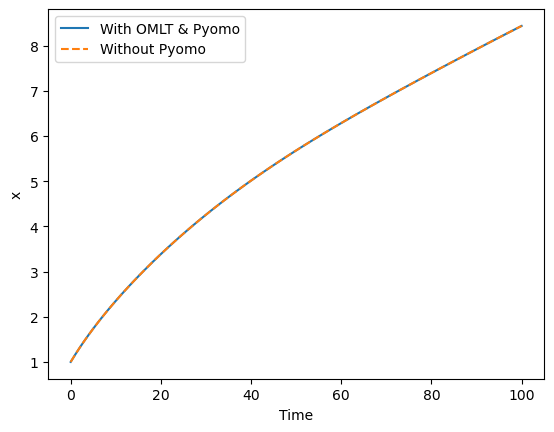

In [55]:
# Import necessary libraries
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
from omlt.neuralnet import ReducedSpaceSmoothNNFormulation
import pyomo.kernel

# --------------------------- Save PyTorch NN and create NN formulation ---------------------- #

# model.nn_x = OmltBlock()
x_input_bounds = [(0,10)]

# Make random data for batch size, input size (dummy input to trace the model)
x_trace = torch.randn(1000, 1, requires_grad=True)

with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    torch.onnx.export(
        x_next_model,
        x_trace,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    write_onnx_model_with_bounds(f.name, None, x_input_bounds)
    print(f"Wrote PyTorch model to {f.name}")
    x_pytorch_model = f.name

# Import NN from ONNX with specified bounds
x_model_pyo = load_onnx_neural_network_with_bounds(x_pytorch_model)
# Remove the temporary file created
os.remove(x_pytorch_model)

# Neural network formulation - used loaded ONNX file
x_formulation = ReducedSpaceSmoothNNFormulation(x_model_pyo)


# ---------------------------------- Set up Pyomo model --------------------------------- #


# Time horizon for the simulation
start_time = 0.0
end_time = 100.0

# Initialize the Concrete Model
model = ConcreteModel()

# Define an index set
model.block_indices = RangeSet(0, 100)

# Create an indexed Block to hold the OmltBlock instances
model.nn_x = Block(model.block_indices, rule=lambda b, i: b.add_component("omlt_block", OmltBlock()))

# Now build formulations for each OmltBlock
for i in model.block_indices:
    model.nn_x[i].omlt_block.build_formulation(x_formulation)


# Make discrete time points within specified bounds
time_points = list(range(int(start_time), int(end_time) + 1)) 
model.t = Set(initialize=time_points)
model.x = Var(model.t, domain=Reals)

# Initial value for x
x_init = 1
model.x[int(start_time)].fix(x_init)


# Create constraint for each time point
def input_connect(m, t):
    if t == m.t.last():
        print(f'Input constraint skipped for last time point, {t}... nothing fed to NN\n')
        return Constraint.Skip  # Skip the last time point
    return m.nn_x[t].omlt_block.inputs[0] == m.x[t]

model.input_constraint = Constraint(model.t, rule=input_connect)

# Constraint to connect outputs of the neural network block to the state variable
def output_connect(m, t):
    if t == m.t.first():
        print(f'Output constraint skipped for first time point, {t}... output is the known initial condition\n')
        return Constraint.Skip  # Skip the first time point
    t_prev = m.t.prev(t)
    return m.x[t] == m.nn_x[t_prev].omlt_block.outputs[0]

model.output_constraint = Constraint(model.t, rule=output_connect)


# --------------------------------- Solve and Plot --------------------------------- #


# Objective function (trivial)
def obj_fxn(m):
    return 1.0

model.obj = Objective(rule=obj_fxn)

# Solver setup and solution
solver = SolverFactory('ipopt')
results = solver.solve(model, tee=True)
print(results)

# Extract and plot results
times = np.array([t for t in model.t])
x_pts = np.array([model.x[t].value for t in times])



# Compare to NN evaluations

x_t = np.zeros(timepts)
x_t[0] = x_init

for t_ind in range(int(end_time)):
    x_val = np.array([x_t[t_ind]])
    x_t[t_ind+1] = x_next_eval(x_val)



plt.figure()
plt.plot(times, x_pts)
plt.plot(times, x_t, linestyle='--')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend(['With OMLT & Pyomo', 'Without Pyomo'])
plt.show()

Real objective

Wrote PyTorch model to C:\Users\Jake\AppData\Local\Temp\tmpfxldaq1l.onnx
Input constraint skipped for last time point, 100... nothing fed to NN

Output constraint skipped for first time point, 0... output is the known initial condition

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros i

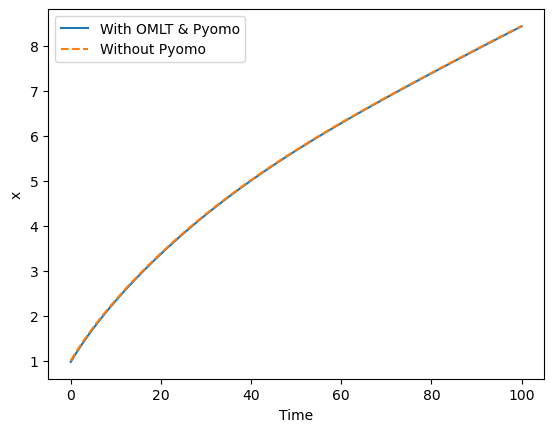

In [65]:
# Import necessary libraries
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
from omlt.neuralnet import ReducedSpaceSmoothNNFormulation
import pyomo.kernel

# --------------------------- Save PyTorch NN and create NN formulation ---------------------- #

# model.nn_x = OmltBlock()
x_input_bounds = [(0,10)]

# Make random data for batch size, input size (dummy input to trace the model)
x_trace = torch.randn(1000, 1, requires_grad=True)

with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    torch.onnx.export(
        x_next_model,
        x_trace,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    write_onnx_model_with_bounds(f.name, None, x_input_bounds)
    print(f"Wrote PyTorch model to {f.name}")
    x_pytorch_model = f.name

# Import NN from ONNX with specified bounds
x_model_pyo = load_onnx_neural_network_with_bounds(x_pytorch_model)
# Remove the temporary file created
os.remove(x_pytorch_model)

# Neural network formulation - used loaded ONNX file
x_formulation = ReducedSpaceSmoothNNFormulation(x_model_pyo)


# ---------------------------------- Set up Pyomo model --------------------------------- #


# Time horizon for the simulation
start_time = 0.0
end_time = 100.0

# Initialize the Concrete Model
model = ConcreteModel()

# Define an index set
model.block_indices = RangeSet(0, 100)

# Create an indexed Block to hold the OmltBlock instances
model.nn_x = Block(model.block_indices, rule=lambda b, i: b.add_component("omlt_block", OmltBlock()))

# Now you can build formulations for each OmltBlock
for i in model.block_indices:
    model.nn_x[i].omlt_block.build_formulation(x_formulation)


# Make discrete time points within specified bounds
time_points = list(range(int(start_time), int(end_time) + 1)) 
model.t = Set(initialize=time_points)
model.x = Var(model.t, domain=Reals)

# Initial value for x
model.x_init = Var(initialize=1)

def init_cond(m):
    return model.x[int(start_time)] == model.x_init
model.init_constraint = Constraint(rule=init_cond)

# Create constraint for each time point
def input_connect(m, t):
    if t == m.t.last():
        print(f'Input constraint skipped for last time point, {t}... nothing fed to NN\n')
        return Constraint.Skip  # Skip the last time point
    return m.nn_x[t].omlt_block.inputs[0] == m.x[t]

model.input_constraint = Constraint(model.t, rule=input_connect)

# Constraint to connect outputs of the neural network block to the state variable
def output_connect(m, t):
    if t == m.t.first():
        print(f'Output constraint skipped for first time point, {t}... output is the known initial condition\n')
        return Constraint.Skip  # Skip the first time point
    t_prev = m.t.prev(t)
    return m.x[t] == m.nn_x[t_prev].omlt_block.outputs[0]

model.output_constraint = Constraint(model.t, rule=output_connect)

# Objective function (non-trivial)
def obj_fxn(m):
    return (m.x[40] - 5)**2

model.obj = Objective(rule=obj_fxn)

# Objective function (trivial)
# def obj_fxn(m):
#     return 1

# model.obj = Objective(rule=obj_fxn)



# --------------------------------- Solve and Plot --------------------------------- #


# Solver setup and solution
solver = SolverFactory('ipopt')
results = solver.solve(model, tee=True)
print(results)
print(f'Initial x-value: {model.x_init.value}')
print(f'Resulting x[40] value: {model.x[40].value}')

# Extract and plot results
times = np.array([t for t in model.t])
x_pts = np.array([model.x[t].value for t in times])



# Compare to NN evaluations
x_t = np.zeros(timepts)
x_t[0] = x_init

for t_ind in range(int(end_time)):
    x_val = np.array([x_t[t_ind]])
    x_t[t_ind+1] = x_next_eval(x_val)



plt.figure()
plt.plot(times, x_pts)
plt.plot(times, x_t, linestyle='--')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend(['With OMLT & Pyomo', 'Without Pyomo'])
plt.show()